In [1]:
from robot_vlp.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, FIGURES_DIR, MODELS_DIR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import robot_vlp.stats.navigation_performance as nav
import robot_vlp.modeling.EKF as ekf
import robot_vlp.data_collection.communication as c
import robot_vlp.data_collection.experment_processing as ep
from robot_vlp.stats.log_stats import log_stats

from tensorflow.keras.models import load_model
import robot_vlp.data.preprocessing as p

# Load the model (automatically detects format)
model = load_model(MODELS_DIR / 'navigation_neural_nets/rnn.keras')  # or 'path/to/model.h5'




color_scheme = {
    'real': '#000000',   # black
    'rnn': '#1f77b4',    # blue
    'ekf':'#2ca02c',    # green
    'vlp':  '#ff7f0e',    # orange
    'encoder': '#7f7f7f' # grey
}

linestyles = {
    'rnn': '-',
    'ekf': '--',
    'vlp': ':',
    'encoder': '-.',
    'real':(0, (1, 1)) 
}

display_labels = {
    'rnn': 'LSTM',
    'encoder': 'Enc. Odom',
    'ekf': 'EKF',
    'vlp': 'VLP',
    'real': 'Real',
}


%load_ext autoreload
%autoreload 2


2025-12-02 09:15:14.151 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp
2025-12-02 09:15:28.341438: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-02 09:15:28.341463: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-02 09:15:28.341470: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-02 09:15:28.341506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-02 09:15:28.341516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import models

In [2]:
rnn_mod = load_model(MODELS_DIR / 'navigation_neural_nets/rnn.keras') 

def vec_to_ang(pre_ang):
    return np.arctan2(pre_ang[:,0], pre_ang[:,1]) 

def normalize_angle_deg(angle):
    """Normalize an angle in degrees to the range [-180, 180]."""
    return (angle + 180) % 360 - 180

def normalize_angle_rad(angle):
    """Normalize an angle in radians to the range [-π, π]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def preprocess_df(df):
    X = df[['vlp_x_hist', 'vlp_y_hist','vlp_heading_hist_rad','vlp_heading_change_rad', 'encoder_heading_change_rad', 'encoder_heading_hist_rad', 'encoder_x_hist','encoder_y_hist']].values
    y = df[['x_hist', 'y_hist','heading_hist_rad']].values
    X_win, y_win, m_win = p.window_data(X, y, y, overlap = 0.999999, window_len = 20)
    return X_win, y_win, m_win


df_lst = []
for i in range(10):
    test_file = INTERIM_DATA_DIR / 'exp_vive_navigated_paths'/f'exp1_{i}_high_acc.csv'
    df = pd.read_csv(test_file)
    df_lst.append(df)

ekf.calc_err_stats(df_lst[:-1])


{'R_x': 0.0012091360236459105,
 'R_y': 0.0011077760034705292,
 'R_theta': 0.04970905192458874,
 'Q_theta': 0.00021652921772540736,
 'Q_theta_no_turn': 3.982763121767624e-05,
 'Q_dist': 1.7424913153369338e-06}

In [3]:
def run_ekf_on_df(df):

    # err_stats = {
    # 'R_x': np.float64(0.0011877283113252916),
    # 'R_y': np.float64(0.001091556953648103),
    # 'R_theta': np.float64(0.04948532100320507),
    # 'Q_theta': np.float64(0.0002164107393016196),
    # 'Q_theta_no_turn': np.float64(4.006326132012649e-05),
    # 'Q_dist': np.float64(1.761140402328462e-06)
    # }

    err_stats = { # computed from the first 9 files
        'R_x': 0.0012091360236459105,
        'R_y': 0.0011077760034705292,
        'R_theta': 0.04970905192458874,
        'Q_theta': 0.00021652921772540736,
        'Q_theta_no_turn': 3.982763121767624e-05,
        'Q_dist': 1.7424913153369338e-06
    }


    ekf_df = ekf.run_ekf(df.iloc[:].reset_index(drop = True),err_stats)

    ekf_pre_loc = ekf_df[['EKF_x', 'EKF_y']].values
    ekf_pre_rad  = ekf_df['EKF_heading_rad'].values 
    ekf_loc_errs = nav.calc_loc_err(ekf_pre_loc, df[['x_hist', 'y_hist']].values)
    ekf_ang_errs = ekf_pre_rad - df['heading_hist_rad'].values
    ekf_ang_errs = np.array([normalize_angle_rad(ang) for ang in ekf_ang_errs])

    return ekf_df,ekf_ang_errs, ekf_loc_errs



In [4]:
df = df_lst[-1]

patch =  df[['x_hist', 'y_hist', 'heading_hist_rad']].iloc[19].values - df[['encoder_x_hist', 'encoder_y_hist', 'encoder_heading_hist_rad']].iloc[19].values
df[['encoder_x_hist', 'encoder_y_hist', 'encoder_heading_hist_rad']] = df[['encoder_x_hist', 'encoder_y_hist', 'encoder_heading_hist_rad']].values + patch

X_win, y_win, m_win = preprocess_df(df)
X_win = np.nan_to_num(X_win, nan = 0)
y_win = np.nan_to_num(y_win, nan = 0)

ekf_df,ekf_ang_errs, ekf_loc_errs = run_ekf_on_df(df.iloc[20:320])
ekf_ang_errs = ekf_ang_errs[:300] * 180/np.pi
ekf_loc_errs = ekf_loc_errs[:300]

In [5]:
rnn_pre_loc, rnn_pre_ang = rnn_mod.predict(X_win)
rnn_loc_errs = nav.calc_loc_err(rnn_pre_loc, y_win[:,:2])[:300]
rnn_ang_errs = vec_to_ang(rnn_pre_ang) - y_win[:,2]
rnn_ang_errs = np.array([normalize_angle_rad(ang) for ang in rnn_ang_errs])[:300] * 180/np.pi

vlp_ang_errs = (y_win[:,2] -  X_win[:,-1,2])
vlp_ang_errs = np.array([normalize_angle_rad(ang) for ang in vlp_ang_errs])[:300]* 180/np.pi

encoder_ang_ers =  X_win[:,-1,5]- y_win[:,2]
encoder_ang_ers = abs(np.array([normalize_angle_rad(ang) for ang in encoder_ang_ers]))[:300]* 180/np.pi

encoder_loc_errs = nav.calc_loc_err(X_win[:,-1,-2:], y_win[:,:2])[:300]

vlp_loc_errs = nav.calc_loc_err(X_win[:,-1,:2], y_win[:,:2])[:300]




print(f"vlp pos errs:{vlp_loc_errs.mean()}")
print(f"encoder pos errs:{encoder_loc_errs.mean()}")
print(f"LSTM pos errs:{rnn_loc_errs.mean()}")
print(f"ekf pos errs:{ekf_loc_errs.mean()}")


print(f"VLP heading errs:{np.abs(vlp_ang_errs).mean() }")
print(f"encoder heading errs:{np.abs(encoder_ang_ers).mean()}")
print(f"LSTM heading errs:{np.abs(rnn_ang_errs).mean()}")
print(f"ekf heading errs:{np.abs(ekf_ang_errs).mean()}")

2025-12-02 09:15:29.318445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
vlp pos errs:0.03540542033646342
encoder pos errs:0.06941831921087847
RNN pos errs:0.019798896498900417
ekf pos errs:0.0344865071772824
VLP heading errs:9.975040094592842
encoder heading errs:9.189434148280906
RNN heading errs:1.9885223018064213
ekf heading errs:3.507836976311449


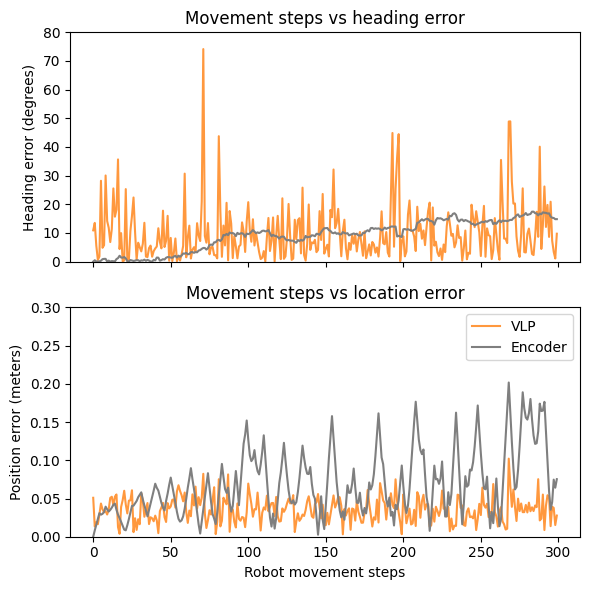

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# Heading error
axes[0].plot(abs(vlp_ang_errs),
             label='VLP',
             color=color_scheme['vlp'],
             alpha=0.8)

axes[0].plot(abs(encoder_ang_ers),
             label='Enc. Odom',
             color=color_scheme['encoder'])

axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

# Location error
axes[1].plot(vlp_loc_errs,
             label='VLP',
             color=color_scheme['vlp'],
             alpha=0.8)

axes[1].plot(encoder_loc_errs,
             label='Enc. Odom',
             color=color_scheme['encoder'])

axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()


axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_training_performance_vlp_enc_errs.png", dpi=300)
plt.show()


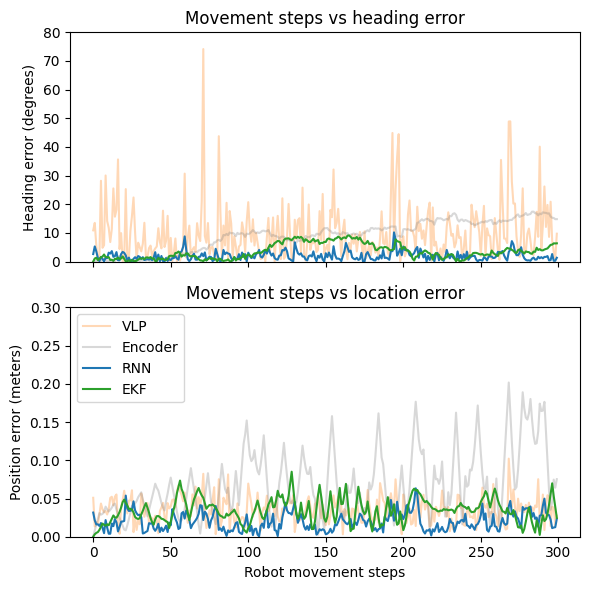

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# Heading error overlay
axes[0].plot(abs(vlp_ang_errs),
             label='VLP',
             color=color_scheme['vlp'],
            #  linestyle=linestyles['vlp'],
             alpha=0.3)

axes[0].plot(abs(encoder_ang_ers),
             label='Enc. Odom',
             color=color_scheme['encoder'],
            #  linestyle=linestyles['encoder'],
             alpha=0.3)

axes[0].plot(abs(rnn_ang_errs),
             label='LSTM',
             color=color_scheme['rnn'],
            #  linestyle=linestyles['rnn'],
             alpha=1)

axes[0].plot(abs(ekf_ang_errs),
             label='EKF',
             color=color_scheme['ekf'],
            #  linestyle=linestyles['ekf'],
             alpha=1)

axes[0].set_title('Movement steps vs heading error')
axes[0].set_ylabel('Heading error (degrees)')
axes[0].set_xticklabels([])

# Location error overlay
axes[1].plot(vlp_loc_errs,
             label='VLP',
             color=color_scheme['vlp'],
            #  linestyle=linestyles['vlp'],
             alpha=0.3)

axes[1].plot(encoder_loc_errs,
             label='Enc. Odom',
             color=color_scheme['encoder'],
            #  linestyle=linestyles['encoder'],
             alpha=0.3)

axes[1].plot(rnn_loc_errs,
             label='LSTM',
             color=color_scheme['rnn'],
            #  linestyle=linestyles['rnn'],
             alpha=1)

axes[1].plot(ekf_loc_errs,
             label='EKF',
             color=color_scheme['ekf'],
            #  linestyle=linestyles['ekf'],
             alpha=1)

axes[1].set_title('Movement steps vs location error')
axes[1].set_ylabel('Position error (meters)')
axes[1].set_xlabel('Robot movement steps')
axes[1].legend()

axes[0].set_ylim(0,80)
axes[1].set_ylim(0, 0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_training_performance_all_errs.png", dpi=300)
plt.show()


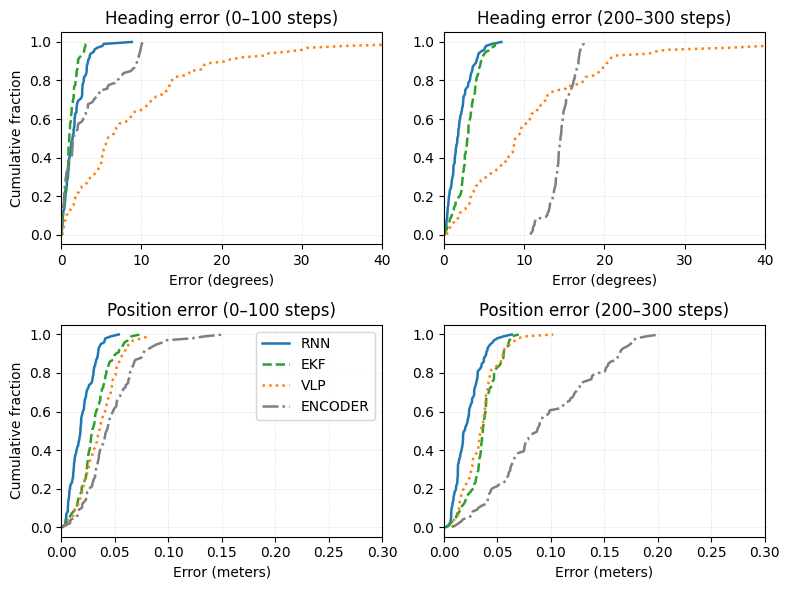

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

steps_early = slice(0, 100)
steps_late = slice(-100, None)

# Plotting function
def plot_cdf(ax, data, label, color, linestyle):
    sorted_data = np.sort(data)
    yvals = np.linspace(0, 1, len(sorted_data))
    ax.plot(sorted_data, yvals, label=label, color=color, linestyle=linestyle, linewidth=1.8)

# --- Heading error (absolute degrees)
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_ang_errs, ekf_ang_errs, vlp_ang_errs, encoder_ang_ers]
):
    plot_cdf(axes[0, 0], np.abs(err_array[steps_early]), display_labels.get(model, model), color_scheme[model], linestyles[model])
    plot_cdf(axes[0, 1], np.abs(err_array[steps_late]) , display_labels.get(model, model), color_scheme[model], linestyles[model])

axes[0, 0].set_title("Heading error (0–100 steps)")
axes[0, 1].set_title("Heading error (200–300 steps)")
axes[0, 0].set_ylabel("Cumulative fraction")
axes[0, 0].set_xlabel("Error (degrees)")
axes[0, 1].set_xlabel("Error (degrees)")


# --- Location error
for model, err_array in zip(
    ['rnn', 'ekf', 'vlp', 'encoder'],
    [rnn_loc_errs, ekf_loc_errs, vlp_loc_errs, encoder_loc_errs]
):
    plot_cdf(axes[1, 0], err_array[steps_early], display_labels.get(model, model), color_scheme[model], linestyles[model])
    plot_cdf(axes[1, 1], err_array[steps_late], display_labels.get(model, model), color_scheme[model], linestyles[model])

axes[1, 0].set_title("Position error (0–100 steps)")
axes[1, 1].set_title("Position error (200–300 steps)")
axes[1, 0].set_ylabel("Cumulative fraction")
axes[1, 0].set_xlabel("Error (meters)")
axes[1, 1].set_xlabel("Error (meters)")

axes[0, 0].set_xlim(0,40)
axes[0, 1].set_xlim(0,40)
axes[1, 0].set_xlim(0,0.3)
axes[1, 1].set_xlim(0,0.3)



# Final layout tweaks
axes[1, 0].legend()
for ax in axes.flat:
    ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_training_performance_cdf_comparison.png", dpi=300)
plt.show()


In [9]:
steps_early = slice(0, 100)
steps_late  = slice(-100, None)

def _median_p90(x):
    x = np.asarray(x)
    if x.size == 0:
        return np.nan, np.nan
    return float(np.median(x)), float(np.percentile(x, 90))

def _split_stats(arr):
    med_e, p90_e = _median_p90(arr[steps_early])
    med_l, p90_l = _median_p90(arr[steps_late])
    return [med_e, p90_e, med_l, p90_l]

def _make_df(arr_dict):
    cols = pd.MultiIndex.from_product(
        [['First 100', 'Last 100'], ['Median', 'P90']],
        names=['Split', 'Metric']
    )
    rows, idx = [], []
    for model, arr in arr_dict.items():
        rows.append(_split_stats(arr))
        idx.append(model)
    return pd.DataFrame(rows, index=idx, columns=cols)

# --- Build arrays consistent with your plotting code ---
# Handle the encoder heading name typo gracefully
try:
    _encoder_ang = encoder_ang_errs
except NameError:
    _encoder_ang = encoder_ang_ers  # as in your snippet

heading_arrays = {
    'LSTM':     np.abs(rnn_ang_errs),
    'EKF':     np.abs(ekf_ang_errs),
    'VLP':     np.abs(vlp_ang_errs),
    'Enc. Odom': np.abs(_encoder_ang),
}

position_arrays = {
    'LSTM':     rnn_loc_errs,
    'EKF':     ekf_loc_errs,
    'VLP':     vlp_loc_errs,
    'Enc. Odom': encoder_loc_errs,
}

heading_stats_df  = _make_df(heading_arrays)
position_stats_df = _make_df(position_arrays)

# View rounded results
print("\n=== Heading (deg): Median & P90 ===")
print(heading_stats_df.round(4))
print("\n=== Position (m): Median & P90 ===")
print(position_stats_df.round(4))

# Optional: export
# heading_stats_df.round(4).to_csv('heading_median_p90_first_last100.csv')
# position_stats_df.round(4).to_csv('position_median_p90_first_last100.csv')
# heading_stats_df.round(4).to_latex('heading_median_p90_first_last100.tex')
# position_stats_df.round(4).to_latex('position_median_p90_first_last100.tex')



=== Heading (deg): Median & P90 ===
Split   First 100          Last 100         
Metric     Median      P90   Median      P90
RNN        1.4027   3.3269   1.6755   4.0533
EKF        1.0003   2.0972   2.9425   4.6258
VLP        5.8008  20.5711   8.9357  20.5916
ENCODER    1.5667   9.5574  14.5256  16.7792

=== Position (m): Median & P90 ===
Split   First 100         Last 100        
Metric     Median     P90   Median     P90
RNN        0.0179  0.0343   0.0190  0.0395
EKF        0.0289  0.0512   0.0363  0.0558
VLP        0.0353  0.0580   0.0342  0.0550
ENCODER    0.0423  0.0764   0.0870  0.1645


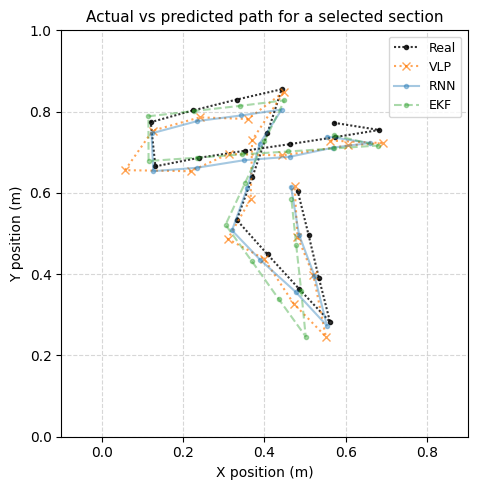

In [10]:
s = 280
e = 300

# Plotting parameters
xlim = (-0.1, 0.9)
ylim = (0, 1)

fig, ax = plt.subplots(figsize=(6, 5))

# Real path
ax.plot(ekf_df['x_hist'].iloc[s:e], ekf_df['y_hist'].iloc[s:e],
        label='Real', marker='.', linestyle=linestyles['real'],
        color=color_scheme['real'], alpha=0.8)

# VLP path
ax.plot(ekf_df['vlp_x_hist'].iloc[s:e], ekf_df['vlp_y_hist'].iloc[s:e],
        label='VLP', marker='x', linestyle=linestyles['vlp'],
        color=color_scheme['vlp'], alpha=0.7)

# LSTM path
ax.plot(rnn_pre_loc[s+1:e+1, 0], rnn_pre_loc[s+1:e+1, 1],
        label='LSTM', marker='.', linestyle=linestyles['rnn'],
        color=color_scheme['rnn'], alpha=0.4)

# EKF path
ax.plot(ekf_df['EKF_x'].iloc[s:e], ekf_df['EKF_y'].iloc[s:e],
        label='EKF', marker='.', linestyle=linestyles['ekf'],
        color=color_scheme['ekf'], alpha=0.4)

# Axes formatting
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.5)

ax.set_title("Actual vs predicted path for a selected section", fontsize=11)
ax.set_xlabel("X position (m)", fontsize=10)
ax.set_ylabel("Y position (m)", fontsize=10)

ax.legend(fontsize=9, frameon=True)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_training_performance_demonstration.png', dpi=300)
plt.show()


In [12]:
import numpy as np

# Assumes you already have these in the notebook:
# rnn_ang_errs, rnn_loc_errs
# ekf_ang_errs, ekf_loc_errs
# enc_ang_errs, enc_loc_errs
# vlp_ang_errs, vlp_loc_errs
# and calc_errors(...) if needed upstream

def _window_for_model(arr, model_key):
    return arr[20:320] if model_key == 'rnn' else arr[:300]

def _first100(arr):
    return arr[:100]

def _last100(arr):
    return arr[-100:]

model_map = {
    'rnn':     ('rnn', rnn_ang_errs, rnn_loc_errs),
    'ekf':     ('ekf', ekf_ang_errs, ekf_loc_errs),
    'vlp':     ('vlp', vlp_ang_errs, vlp_loc_errs),
    'encoder': ('enc', encoder_ang_ers, encoder_loc_errs),
}

npz_payload = {}
for label, (model_key, ang_arr, pos_arr) in model_map.items():
    window_heading = _window_for_model(ang_arr, model_key)
    window_position = _window_for_model(pos_arr, model_key)

    npz_payload[f'{label}_heading'] = np.abs(_last100(window_heading))
    npz_payload[f'{label}_heading_first100'] = np.abs(_first100(window_heading))

    npz_payload[f'{label}_position'] = _last100(window_position)
    npz_payload[f'{label}_position_first100'] = _first100(window_position)

np.savez('testing_last100_errors.npz', **npz_payload)

print("Wrote testing_last100_errors.npz with first & last 100-step arrays")

Wrote testing_last100_errors.npz with first & last 100-step arrays
